In [1]:
import pandas as pd
from pathlib import Path
import os
from collections import Counter
import re

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [2]:
CODE_REPO = "company_da_codes"

def read_code(repo = CODE_REPO):
    data_root = Path(repo)

    texts = []

    for root, dirs, files in os.walk(data_root):
        for f in files:
            if f.endswith(".py"):
                text = open(Path(root)/ f,'r').read().split('\n')
                texts += [t.strip() for t in text]

    texts = [t for t in texts if len(t) > 0]
    return texts

def find_dataframe_ops(s):
    return re.findall(r"(df\.\w+)\(", s)

def find_pandas_ops(s):
    return re.findall(r"(pd\.\w+)\(", s)

def find_join_table(s):
    """这里是由于公司组织pipeline的特殊写法, 所以要单独处理得到join表操作"""
    return re.findall(r"(\w+DfSequence)", s)

def find_row_col_selection(s):
    return re.findall(r"(df\.loc)\[", s) \
        + re.findall(r"(df\.iloc)\[", s) \
        + re.findall(r"(df\.ix)\[", s) \
        + re.findall(r"(df\[)", s)

def parse_codes(texts):
    ops = []
    for line in texts:
        ops += find_dataframe_ops(line)
        ops += find_pandas_ops(line)
        ops += len(find_join_table(line)) * ["pd.merge"]
        ops += len(find_row_col_selection(line)) * ["df.loc"]
    
    ops = pd.DataFrame(Counter(ops).most_common(), columns = ['op','op_count'])
    return ops

In [3]:
texts = read_code()
summary = parse_codes(texts)

In [4]:
f"我司共有 {len(texts)} 行有效的Python数据分析代码"

'我司共有 35162 行有效的Python数据分析代码'

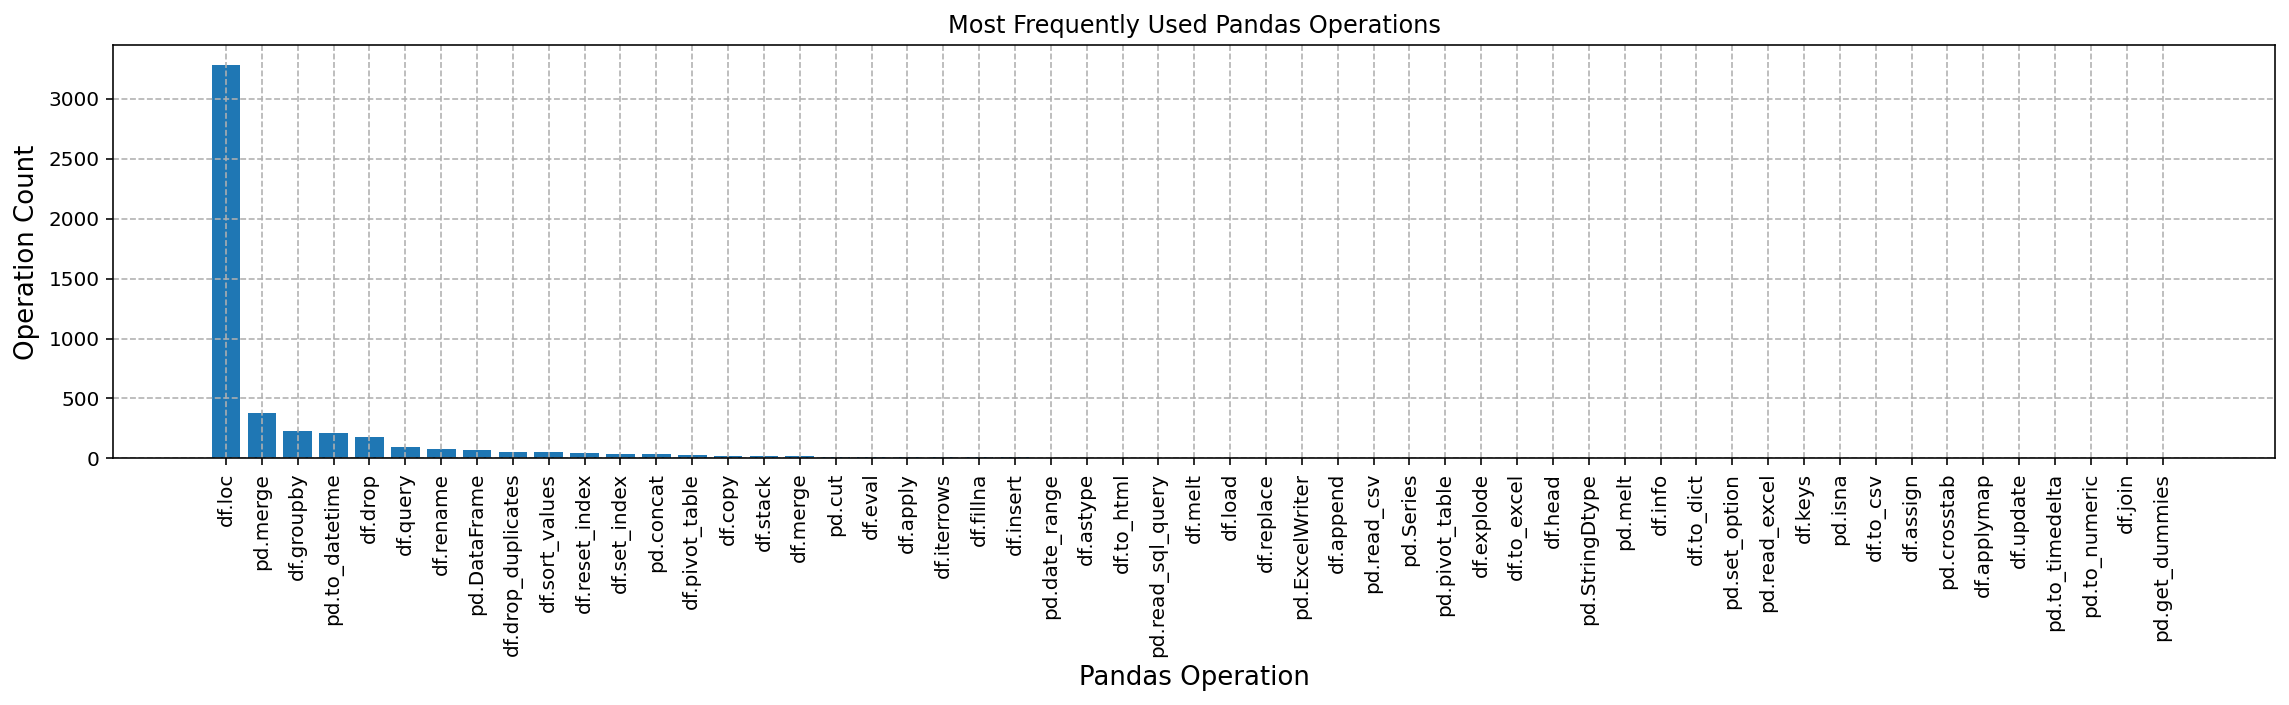

In [5]:
fig, ax = plt.subplots(figsize = (16,5))
plt.bar(summary.op, summary.op_count)
plt.xticks(rotation=90)
plt.xlabel("Pandas Operation", fontsize = 13)
plt.ylabel("Operation Count", fontsize = 13)
plt.grid(linestyle = '--')
plt.title("Most Frequently Used Pandas Operations")
plt.tight_layout()
plt.show()

As can be seen from this figure, data analyst use `df.loc`, `df.iloc`, `df[col]` syntax 3281 times.     

By removing selection operations, we got the following plot.    
  
Unfortunately, I use 2 `iloc` operation in order to produce this figure.    

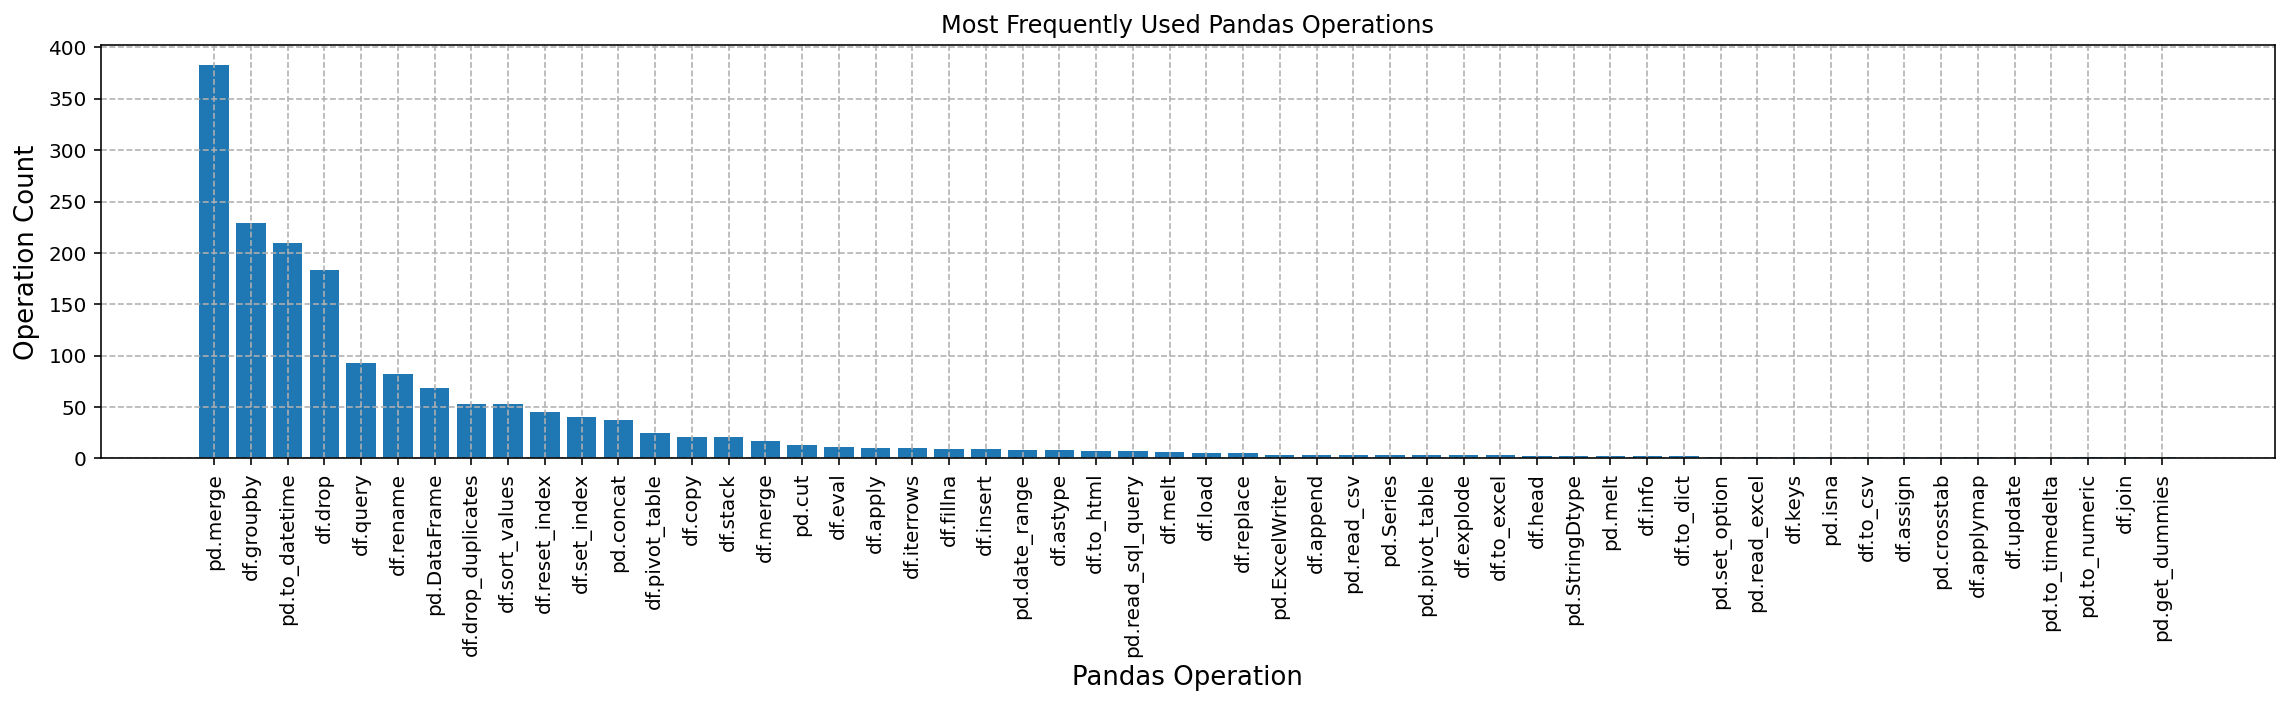

In [6]:
fig, ax = plt.subplots(figsize = (16,5))
plt.bar(summary.iloc[1:].op, summary.iloc[1:].op_count)
plt.xticks(rotation=90)
plt.xlabel("Pandas Operation", fontsize = 13)
plt.ylabel("Operation Count", fontsize = 13)
plt.grid(linestyle = '--')
plt.title("Most Frequently Used Pandas Operations")
plt.tight_layout()
plt.show()

我们可以看到分析师最常用的操作为 
- Join表操作
- GroupBy操作
- 转换时间类型
- 去除列
- query条件语句(类似于where)
- 重命名单元格 / 列
- 转换为DataFrame
- 去重复
- 排序
- 重制索引

接下来我们看看分析师对科学计算包的应用程度

In [7]:
def import_package_counts(package_name):
    cnt = len([t for t in texts if re.search(package_name,t)])
    print("Analysts imported {} {} times".format(package_name, cnt))

In [8]:
import_package_counts('sklearn')

Analysts imported sklearn 4 times


In [9]:
import_package_counts('scipy')

Analysts imported scipy 0 times


In [10]:
import_package_counts('statsmodels')

Analysts imported statsmodels 0 times


In [11]:
import_package_counts('xgboost')

Analysts imported xgboost 0 times


In [12]:
import_package_counts('tensorflow')

Analysts imported tensorflow 0 times


除了我个人在定时调度任务中使用过4次sklearn以外，其余分析师都没有使用过scipy, statsmodels, xgboost, tensorflow等库

In [13]:
import_package_counts('write_to_database')

Analysts imported write_to_database 244 times


244 次写入数据库操作

In [14]:
import_package_counts('predict')

Analysts imported predict 4 times


使用Predict方法4次